# Demo of a decision tree Leo transpilation - MNIST dataset

Decision trees are a powerful tool, even for image classification tasks like the MNIST dataset, which contains images of handwritten digits. We show the inference of decision trees for the MNIST dataset is possible in a zero knowledge environment.

## Define function to download the dataset

In [8]:
import gzip
import os
import shutil

import requests


def download_and_extract_dataset(url, save_path, folder_path):
    """Download and extract dataset if it doesn't exist."""
    if not os.path.exists(save_path):
        print(f"Downloading {os.path.basename(save_path)}...")
        response = requests.get(url)
        with open(save_path, "wb") as file:
            file.write(response.content)

        decompressed_file_name = os.path.splitext(os.path.basename(save_path))[0]
        decompressed_file_path = os.path.join(folder_path, decompressed_file_name)

        with gzip.open(save_path, "rb") as f_in:
            with open(decompressed_file_path, "wb") as f_out:
                shutil.copyfileobj(f_in, f_out)

        print(f"{decompressed_file_name} downloaded and extracted.")
    else:
        print(f"{os.path.basename(save_path)} already exists.")

## Download the dataset

In [9]:
# URLs and filenames
file_info = [
    (
        "http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz",
        "train-images-idx3-ubyte.gz",
    ),
    (
        "http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz",
        "train-labels-idx1-ubyte.gz",
    ),
    (
        "http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz",
        "t10k-images-idx3-ubyte.gz",
    ),
    (
        "http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz",
        "t10k-labels-idx1-ubyte.gz",
    ),
]

folder_name = "tmp/mnist"
folder_path = os.path.join(os.getcwd(), folder_name)

os.makedirs(folder_path, exist_ok=True)  # Create folder if it doesn't exist

# Download and extract each file
for url, file_name in file_info:
    path_to_save = os.path.join(folder_path, file_name)
    download_and_extract_dataset(url, path_to_save, folder_path)

train-images-idx3-ubyte.gz already exists.
train-labels-idx1-ubyte.gz already exists.
t10k-images-idx3-ubyte.gz already exists.
t10k-labels-idx1-ubyte.gz already exists.


## Define function to read the dataset

In [10]:
import numpy as np


def read_idx3_ubyte_image_file(filename):
    """Read IDX3-ubyte formatted image data."""
    with open(filename, "rb") as f:
        magic_num = int.from_bytes(f.read(4), byteorder="big")
        num_images = int.from_bytes(f.read(4), byteorder="big")
        num_rows = int.from_bytes(f.read(4), byteorder="big")
        num_cols = int.from_bytes(f.read(4), byteorder="big")

        if magic_num != 2051:
            raise ValueError(f"Invalid magic number: {magic_num}")

        images = np.zeros((num_images, num_rows, num_cols), dtype=np.uint8)

        for i in range(num_images):
            for r in range(num_rows):
                for c in range(num_cols):
                    pixel = int.from_bytes(f.read(1), byteorder="big")
                    images[i, r, c] = pixel

    return images


def read_idx1_ubyte_label_file(filename):
    """Read IDX1-ubyte formatted label data."""
    with open(filename, "rb") as f:
        magic_num = int.from_bytes(f.read(4), byteorder="big")
        num_labels = int.from_bytes(f.read(4), byteorder="big")

        if magic_num != 2049:
            raise ValueError(f"Invalid magic number: {magic_num}")

        labels = np.zeros(num_labels, dtype=np.uint8)

        for i in range(num_labels):
            labels[i] = int.from_bytes(f.read(1), byteorder="big")

    return labels

## Read the dataset

In [11]:
folder_path = os.path.join(
    os.getcwd(), folder_name
)  # Adjust this path to where you stored the files

train_images = read_idx3_ubyte_image_file(
    os.path.join(folder_path, "train-images-idx3-ubyte")
)
train_labels = read_idx1_ubyte_label_file(
    os.path.join(folder_path, "train-labels-idx1-ubyte")
)
test_images = read_idx3_ubyte_image_file(
    os.path.join(folder_path, "t10k-images-idx3-ubyte")
)
test_labels = read_idx1_ubyte_label_file(
    os.path.join(folder_path, "t10k-labels-idx1-ubyte")
)

print(
    f"Shape of train_images: {train_images.shape}"
)  # Should output "Shape of train_images: (60000, 28, 28)"
print(
    f"Shape of train_labels: {train_labels.shape}"
)  # Should output "Shape of train_labels: (60000,)"
print(
    f"Shape of test_images: {test_images.shape}"
)  # Should output "Shape of test_images: (10000, 28, 28)"
print(
    f"Shape of test_labels: {test_labels.shape}"
)  # Should output "Shape of test_labels: (10000,)"

Shape of train_images: (60000, 28, 28)
Shape of train_labels: (60000,)
Shape of test_images: (10000, 28, 28)
Shape of test_labels: (10000,)


## Process the datasets and train the decision tree classifier

In [12]:
# Reshape the datasets from 3D to 2D
train_images_2d = train_images.reshape(
    train_images.shape[0], -1
)  # -1 infers the size from the remaining dimensions
test_images_2d = test_images.reshape(test_images.shape[0], -1)

# Create the classifier and fit it to the reshaped training data
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=10, random_state=0)
clf.fit(train_images_2d, train_labels)

DecisionTreeClassifier(max_depth=10, random_state=0)

## Evaluate the trained decision tree classifier

In [13]:
from sklearn.metrics import accuracy_score


def acc(y_true, y_pred):
    return accuracy_score(y_true, y_pred) * 100  # Multiply by 100 to get percentage


# Evaluate the baseline model
train_preds_baseline = clf.predict(train_images_2d)
val_preds_baseline = clf.predict(test_images_2d)
acc_baseline_train = acc(train_preds_baseline, train_labels)
acc_baseline_val = acc(val_preds_baseline, test_labels)
print(
    "Training accuracy for our baseline (using all pixel features): "
    f"{acc_baseline_train:.2f}%"
)
print(
    "Validation accuracy for our baseline (using all pixel features): "
    f"{acc_baseline_val:.2f}%"
)

Training accuracy for our baseline (using all pixel features): 89.95%
Validation accuracy for our baseline (using all pixel features): 86.57%


## Plot the trained decision tree classifier

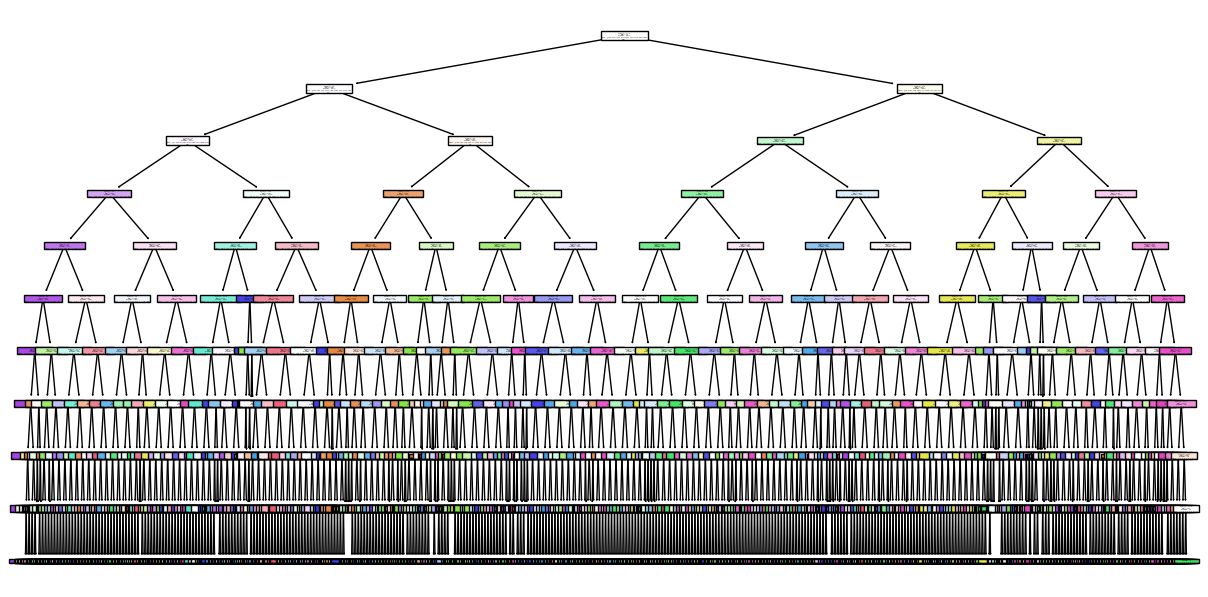

In [14]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(15, 7.5))
plot_tree(clf, filled=True)
plt.show()

## Transpile the model into Leo code
(to speed things up here, we only use the first 200 training data images for numerical validation of the transpiled code instead of the entire training dataset)

In [15]:
import logging
import os

from zkml import LeoTranspiler

# Set the logger
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# Transpile the deceision tree into Leo code
lt = LeoTranspiler(model=clf, validation_data=train_images_2d[0:200])
leo_project_path = os.path.join(os.getcwd(), "tmp/mnist")
leo_project_name = "tree_mnist_1"
lt.to_leo(path=leo_project_path, project_name=leo_project_name)

INFO:root:Computing number ranges and fixed-point scaling factor...
INFO:root:Minimum number: -2.0, maximum number: 255. Recommended fixed-point scaling factor: 16, required Leo type: i16
INFO:root:Transpiling model...
INFO:root:Leo program stored


## Let's input one test data image into the Leo and Python model and compare the predictions and labels

In [16]:
# prove and compare the Leo prediction with the Python prediction and the label
zkp = lt.execute(input_sample=test_images_2d[0])
python_prediction = clf.predict([test_images_2d[0]])

print(f"Circuit constraints: {zkp.circuit_constraints}")
print(f"Runtime: {zkp.runtime} seconds")
print(f"Active input count: {zkp.active_input_count}")
print(f"Leo prediction in fixed-point notation: {zkp.output[0]}")
print(f"Leo prediction in decimal notation: {zkp.output_decimal[0]}")
print(f"Python prediction: {python_prediction[0]}")
print(f"Label: {test_labels[0]}")

Circuit constraints: 27116
Runtime: 30.174044132232666 seconds
Active input count: 326
Leo prediction in fixed-point notation: 112
Leo prediction in decimal notation: 7.0
Python prediction: 7
Label: 7


## Let's compare the classification accuracy for the Leo and Python model over the test data images 
(this process may take a few minutes, as we iterate over the test dataset and run the leo code each time)

In [17]:
# Compute the accuracy of the Leo program and the Python program on the test set
num_test_samples = len(test_images_2d)

# let's limit the number of test stamples to 50 to make the computation faster
num_test_samples = min(num_test_samples, 50)

leo_predictions = np.zeros(num_test_samples)
for i in range(num_test_samples):
    leo_predictions[i] = lt.run(input_sample=test_images_2d[i]).output_decimal[0]
    print("Progress: {:.2f}%".format(100 * (i + 1) / num_test_samples), end="\r")

python_predictions = clf.predict(test_images_2d)

leo_accuracy = (
    np.sum(leo_predictions[0:num_test_samples] == test_labels[0:num_test_samples])
    / num_test_samples
)
python_accuracy = (
    np.sum(python_predictions[0:num_test_samples] == test_labels[0:num_test_samples])
    / num_test_samples
)

print(f"Leo accuracy: {100*leo_accuracy} %")
print(f"Python accuracy: {100*python_accuracy} %")

Leo accuracy: 96.0 %
Python accuracy: 96.0 %


## We can also set the model parameters as inputs instead of hardcoding these

In [18]:
leo_project_name = "tree_mnist_2"
lt.to_leo(path=leo_project_path, project_name=leo_project_name, model_as_input=True)

INFO:root:Computing number ranges and fixed-point scaling factor...
INFO:root:Minimum number: -2.0, maximum number: 255. Recommended fixed-point scaling factor: 16, required Leo type: i16
INFO:root:Transpiling model...
INFO:root:Leo program stored


## Let's run the proving again
(we expect the circuit to have more inputs and slightly more constraints now, more inputs, and also the proving to run slightly longer)

In [19]:
# prove and compare the Leo prediction with the Python prediction and the label
zkp = lt.execute(input_sample=test_images_2d[0])
python_prediction = clf.predict([test_images_2d[0]])

print(f"Circuit constraints: {zkp.circuit_constraints}")
print(f"Runtime: {zkp.runtime} seconds")
print(f"Active circuit inputs: {zkp.active_input_count}")
print(f"Leo prediction in fixed-point notation: {zkp.output[0]}")
print(f"Leo prediction in decimal notation: {zkp.output_decimal[0]}")
print(f"Python prediction: {python_prediction[0]}")
print(f"Label: {test_labels[0]}")
print(f"Proof: {zkp.proof}")

Circuit constraints: 28820
Runtime: 75.82860016822815 seconds
Active circuit inputs: 1178
Leo prediction in fixed-point notation: 112
Leo prediction in decimal notation: 7.0
Python prediction: 7
Label: 7
Proof: proof1qqqsqqqqqqqqqqqpqqqqqqqqqqq2tr3ryqmdcgtxj46dsa7dlhafrz5e3gydr885lj6hreg7lzznudgppx4yscwlw35g3dhqlkkleysqdhtv4h0ufexm732y706xfdapymvge8uqv37h96d9myrns6k0w68tczlp7trtjawtrup8tzg9t89gqh5fsz6c77tf45dxycf85e8vka9c8zywakeznvr4wuzy0ecmlxlnfxuk3v40kddy606kf0lqzq7rqqq3dzegv8ha0utyg2snfw5xkqvwj9xkxqc5v9gesf5al6vergnl0v0j4c0rzur7vwq8z80n279cqkupy55wfpymmp8jlmr803t92gv4hg9zacl2587fp7cq2g2d7qu2mn8q92eahyu8z242s03zu9vayexgr4qutntyzfjca25c850z6dpq34vs4ap0dw8nul4xsatvkjujncv4sw4vtt2uw85kd0h7wqursfe3qx2sd6hgtae8fkq2wrsdqkkv26tzee7eyjqdmmj9j922dh3t8sde6rt2f96ym6t0zj45rum49ampxqgvrr5npmyg2mh9jp84jtt8udxyynegkvamf44kqe236fxegsmztsf33ztktns5k70lx7frc3d8nkqdt3ykhdwlp7nrrtkv2h4q37xgd2qyle4sf30k5vwpkj3uja7pmwpv484hq0wa4th7l6zp329je5sqkxau072mfthjwamvqvgaqzrqteyn7a2dc20wxtw0w5dexcw0runypefgmqujxf3